<center><font size = "10"> Week 4 - Ion Channels <center>
<center><font size = "8">Home work SOLUTIONS<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: ELiser Josan Romero

In [1]:
# libraries used
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.optimize import curve_fit


# Ex1. Extracting parameters from experimental data

<font size=3>

You have been provided with a .nwb file describing measurements of a potassium channel.
The Activiation protocol contains current traces for an ion channel voltage clamped at potentials between -90 mV and +80 mV, at 10mV intervals.

Plot each of the traces and inspect them.
For each trace identify the maximum current $I_{max}$ and the activation time constant $ \tau_m $.
You can find $\tau_m$ at each potential value by fitting an exponential function $\displaystyle y = a + b e^{\frac{-x}{\tau_{m}}} $ to the activation curve.
Fit each trace between some start time of your choice (choose carefully) and the point of maximum ionic current.

    
Finally, plot $tau_m$ and $I_k$ against membrane potential (on separate axes). How do they vary with voltage? What does this mean for the behavior of the channel?

[2 pts]



In [2]:
# Open data with python
data_path = 'Group8/ion_channel.nwb'

data = h5py.File(data_path, 'r')
print(*data.keys())
print(data['session_description'][0])

acquisition analysis checksums epochs file_create_date general identifier nwb_version processing session_description session_start_time stimulus
b'4 runs with CHO rKv1.6 at 25c.'


In [3]:
list(data['acquisition']['timeseries'].keys())

['AP',
 'Activation',
 'Deactivation',
 'Inactivation',
 'Ramp',
 'Recovery',
 'VRest']

## Plotting activation trace

In [4]:
# setting plotting functions

def plot_timeseries(timeseries_repetition):
    traces = np.array(timeseries_repetition['data']).transpose()
    if 'x_interval' in timeseries_repetition:
        dts = np.array(timeseries_repetition['x_interval'])
    else:
        dts = np.array((len(traces), ))
    fig = plt.figure()
    ax = plt.subplot(111)
    n=1
    for trace, dt in zip(traces, dts):
        time = np.linspace(0, len(trace) * dt, len(trace))
        ax.plot(time, trace, label='trace: %.0f' %(n)) #label=label)
        n+=1
    plt.legend()
    plt.title(timeseries_repetition.name)
    plt.xlabel("Time (s)")
    plt.ylabel("Current (pA)")
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
        

def plot_recurse(group):
    for k, grp in group.items():
        if hasattr(grp, 'items'):
            if 'data' in grp:
                plot_timeseries(grp)
            else:
                plot_recurse(grp)

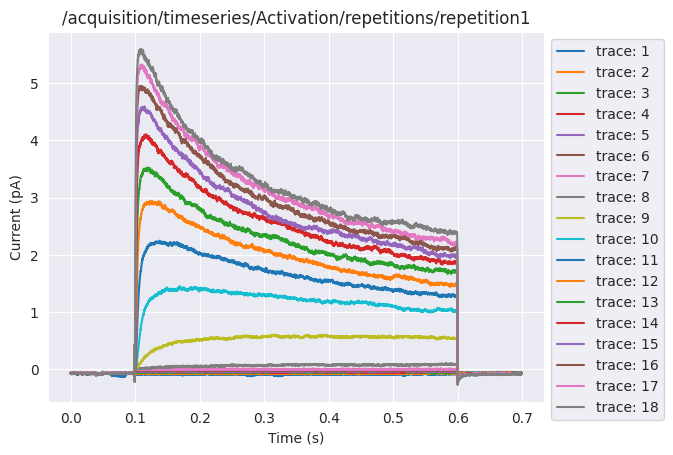

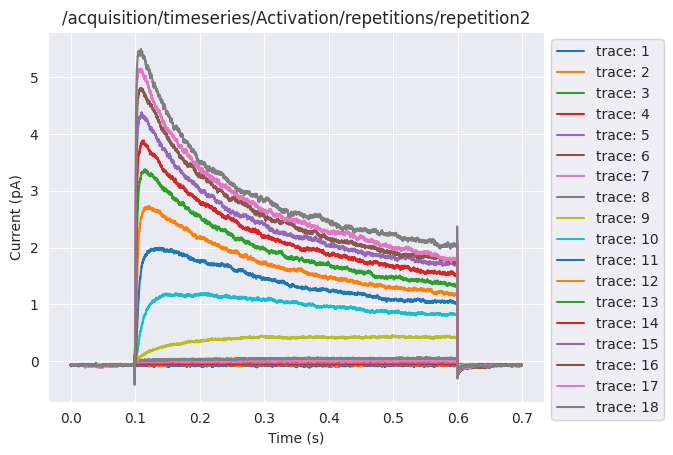

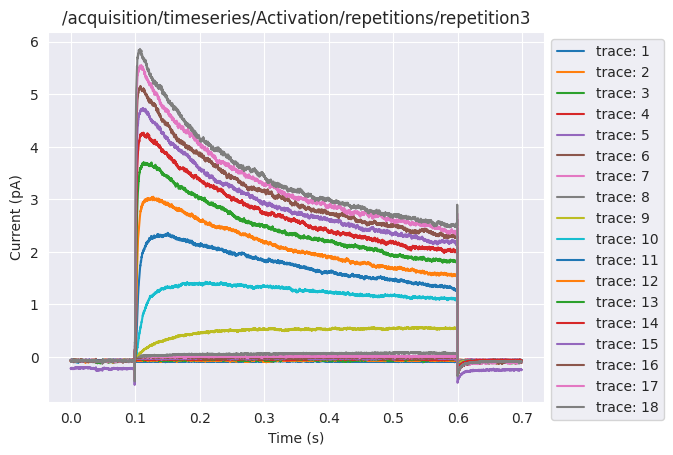

In [5]:
# plot
plot_recurse(data['acquisition']['timeseries']['Activation']['repetitions'])

## Fitting

In [6]:
# looking for directory of data arrays in nwb file
list(data['acquisition']['timeseries']['Activation']['repetitions']['repetition1'].keys())

['amp',
 'capacitance_slow',
 'data',
 'head_temp',
 'n_points',
 'r_series',
 'seal',
 'starting_time',
 'time',
 'trace_ids',
 'trace_times',
 'v_offset',
 'x_interval',
 'x_start']

In [7]:
data['acquisition']['timeseries']['Activation']['repetitions']['repetition1']['data'].shape

(6990, 18)

In [8]:
def func_exp(x, tau):
    return 1 - np.exp(-x/tau)

def plot_exponential_fit(x_data, y_data):
    '''Fit an exponential function to the data in file_name and plot the result.'''
    
    # In this case, we want to compute TAU = popt[0]
    # and to quantify the fitting quality we want to know perr
    popt, pcov = curve_fit(func_exp, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))
    
    plt.figure(figsize=(10,6))
    plt.plot(x_data, y_data, 'xk', label='original data' )
    plt.plot(x_data, func_exp(x_data, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
    plt.legend()
    plt.show()
    
def plot_fits(data, pathway, rep):
    traces = pd.DataFrame(data[pathway+'/repetition'+str(rep)+'/data'])
    dts = np.array(data[pathway+'/repetition'+str(rep)+'/x_interval'])
    starts = np.array(data[pathway+'/repetition'+str(rep)+'/x_start'])
    #dts = np.array((len(traces), ))
    nRow, nCol = traces.shape
    x_end = starts[0] + dts[0]*(float(nRow - 1))
    time = np.linspace(starts[0], x_end, nRow)*1000
    for i in range(nCol):
        plot_exponential_fit(time, traces[i]) #label=label)
    
    """
    for trace, dt in zip(traces.itertuples(), dts):
        time = np.linspace(0, len(trace) * dt, len(trace))
        plot_exponential_fit(time, trace) #label=label)
    """
    plt.title(pathway+'/repetition'+str(rep))
    plt.xlabel("Time (s)")
    plt.ylabel("Current (pA)")
                

In [73]:
# for repetition 1
pathway = 'acquisition/timeseries/Activation/repetitions'
repetition = 1
protocolName = 'Activation'
plot_fits(data, pathway, repetition)


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [116]:
def plotDataFiles(data_pathway, pathway, repID):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(data_pathway, 'r')
    
    # Select on strings what do we want for ploting
    string_data = pathway + str(repID) +'/data'
    string_xinterval = pathway + str(repID) +'/x_interval'
    string_xstart = pathway + str(repID) +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    # each trace in different figures
    data_t = np.transpose(data)
    i = 0
    taus = []
  
    for trace in data_t:
         
        def func_exp(x, tau):
            return np.amax(trace[1010:5991])-(np.amax(trace[1010:5991])-trace[1010])*np.exp(-x/tau)
        plt.figure()
        plt.title('%s repetition %s , trace %s' %(protocolName, repID,i))
        plt.ylabel('voltage traces (mV)')
        plt.xlabel('time (ms)')
        rank_max = np.argmax(trace[1010:5991])+1010
        plt.plot(time[1010:rank_max], trace[1010:rank_max], 'xk', label='original data')
        popt, pcov = curve_fit(func_exp, np.concatenate(time)[1010:rank_max]-102, trace[1010:rank_max])
        taus+=[popt[0]]
        perr = np.sqrt(np.diag(pcov))
        plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
        plt.legend()
        plt.show()

        i += 1
    return taus

In [101]:
def exp_regression(trace, time, protocolName, repID, i, taus):
    taus_ = taus
    def func_exp(x, tau):
            return np.amax(trace[1010:5991])-(np.amax(trace[1010:5991])-trace[1010])*np.exp(-x/tau)
    plt.figure()
    plt.title('%s repetition %s , trace %s' %(protocolName, repID,i))
    plt.ylabel('voltage traces (mV)')
    plt.xlabel('time (ms)')
    rank_max = np.argmax(trace[1010:5991])+1010
    plt.plot(time[1010:rank_max], trace[1010:rank_max], 'xk')
    popt, pcov = curve_fit(func_exp, np.concatenate(time)[1010:rank_max]-102, trace[1010:rank_max])
    taus_+=[popt[0]]
    perr = np.sqrt(np.diag(pcov))
    plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
    plt.legend()
    plt.show()
    return taus_

def lin_regression(trace, time, protocolName, repID, i, taus):
    """
     # Fitting function
    rank_max = np.argmax(trace[1010:5991])+1010
    x = np.concatenate(time)[1010:rank_max]-102
    y = trace[1010:rank_max]
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y) 
    # y = gradient*x + intercept
    # gradient = slope of the regression line; float
    # intercept = intercept of the regression line; float
    # r_value = correlation coefficient; float
    # p_value = two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero; float
    # std_err = standard error of the estimated gradient; float
    
    # Print fitting parameters result, if we want
    # Gradient and intercept are the parameters to be computed
    # You can quantify the quality of the fitting
    # by comparing r, p and std

    print ('gradient =', gradient)
    print ('intercept =', intercept)
    print ('r_value =', r_value)
    print ('p_value =', p_value)
    print ('std_err =', std_err)
    
    # Prepare predicted line for plotting 
    mn=np.min(x)
    mx=np.max(x)
    x1=np.linspace(mn,mx,500)
    y1=gradient*x1+intercept
    
    plt.figure()
    # Plot data and regresion line

    plt.title('%s repetition %s , trace %s' %(protocolName, repID,i))
    plt.ylabel('voltage traces (mV)')
    plt.xlabel('time (ms)')
    plt.plot(x,y,'xk', x1, y1, '-r')
    plt.legend()
    plt.show()
    """
    taus_ = taus
    def func_exp(x, tau):
            return np.amax(trace[1010:5991])-(np.amax(trace[1010:5991])-trace[1010])*np.exp(-x/tau)
    plt.figure()
    plt.title('%s repetition %s , trace %s' %(protocolName, repID,i))
    plt.ylabel('voltage traces (mV)')
    plt.xlabel('time (ms)')
    rank_max = np.argmax(trace[1010:5991])+1010
    plt.plot(time[1010:rank_max], trace[1010:rank_max], 'xk')
    popt, pcov = curve_fit(func_exp, np.concatenate(time)[1010:rank_max]-102, trace[1010:rank_max])
    taus_+=[popt[0]]
    perr = np.sqrt(np.diag(pcov))
    plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
    plt.legend()
    plt.show()
    return taus_

def plotDataFiles(data_pathway, pathway, repID):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(data_pathway, 'r')
    
    # Select on strings what do we want for ploting
    string_data = pathway + str(repID) +'/data'
    string_xinterval = pathway + str(repID) +'/x_interval'
    string_xstart = pathway + str(repID) +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)]
    x_interval = open_data[(string_xinterval)]
    x_start = open_data[(string_xstart)]
    
    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    # each trace in different figures
    data_t = np.transpose(data)
    i = 0
    taus = []
    for trace in data_t:
        if i <= 6:
            lin_regression(trace, time, protocolName, repID, i)
        else:
            taus+= exp_regression(trace, time, protocolName, repID, i, taus)
              
        

        i += 1
    return taus

C:\Users\josan\AppData\Local\Temp\ipykernel_28016\3713472454.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(time[1010:rank_max], func_exp(time[1010:rank_max]-102, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))


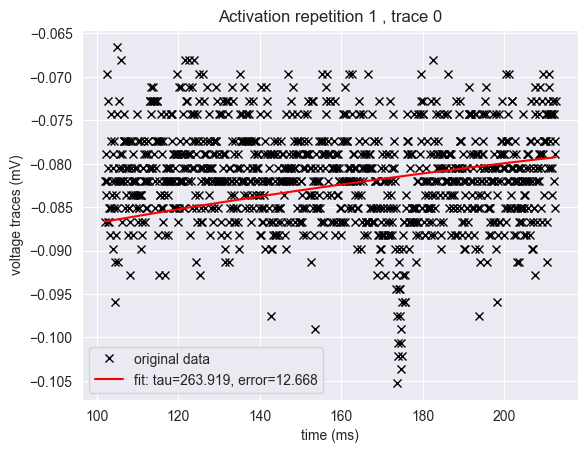

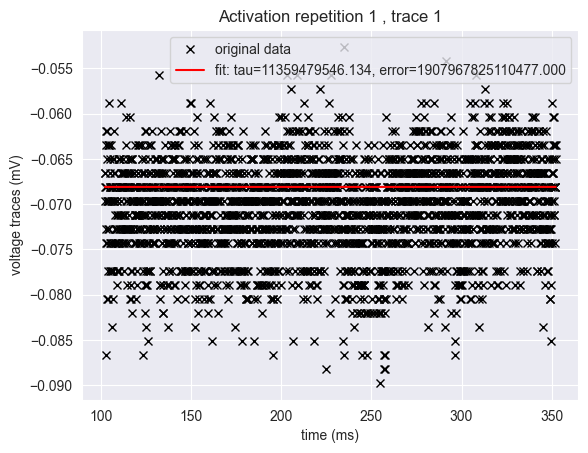

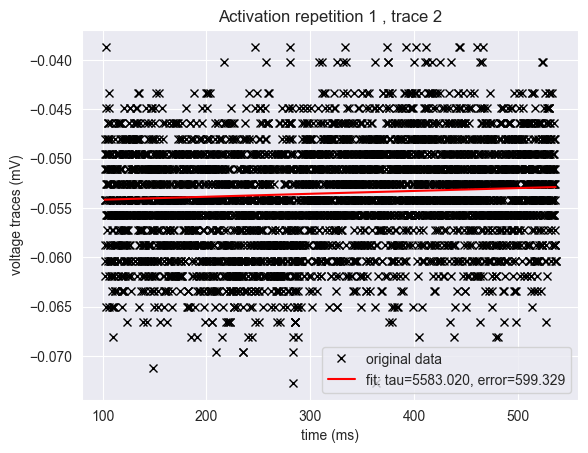

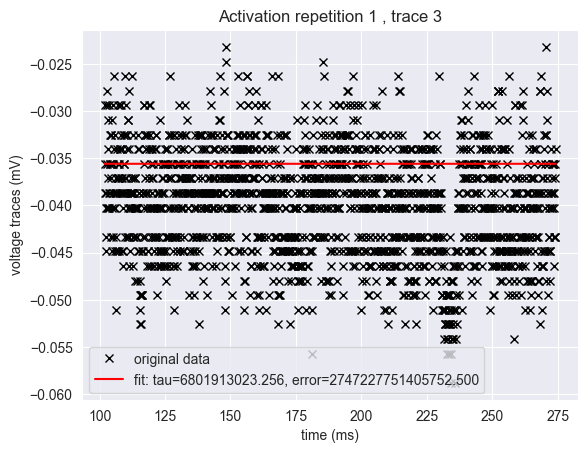

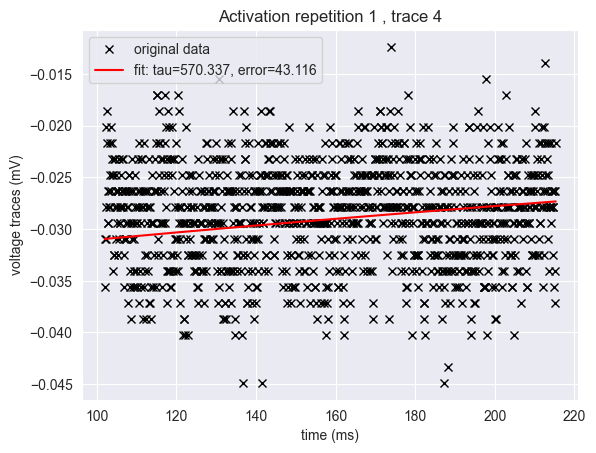

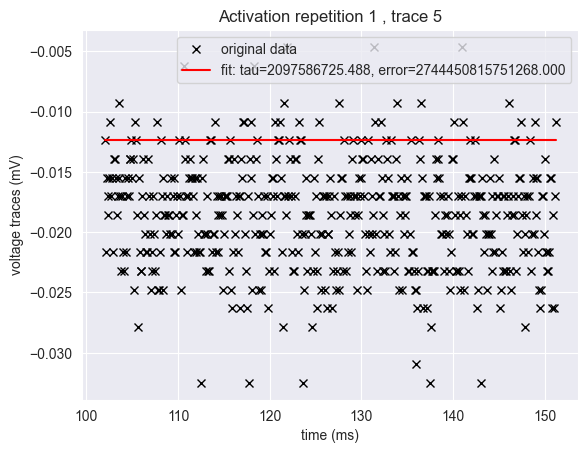

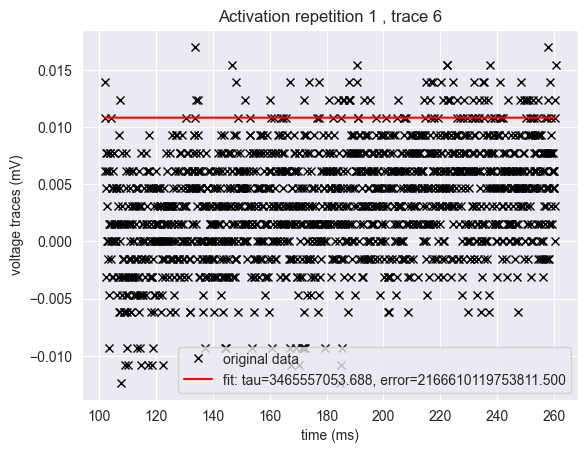

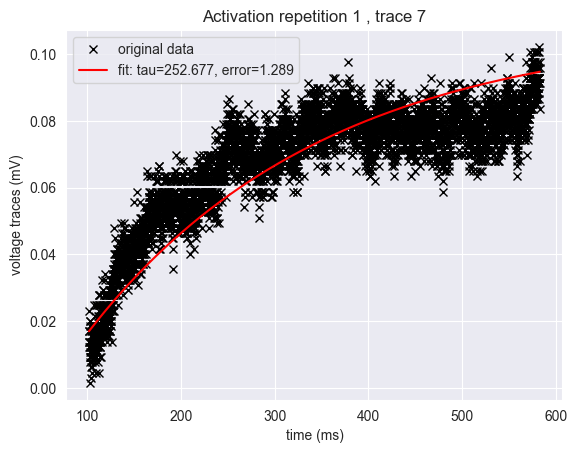

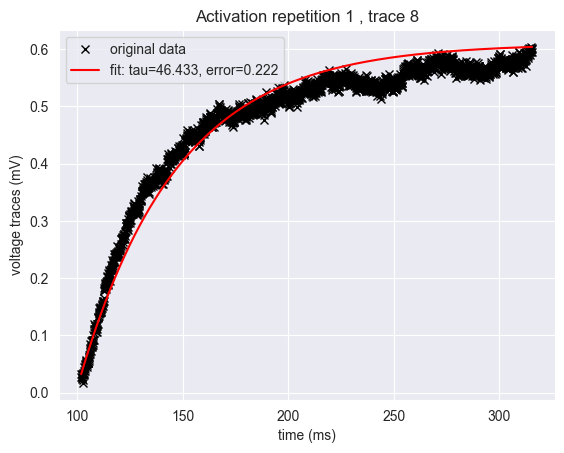

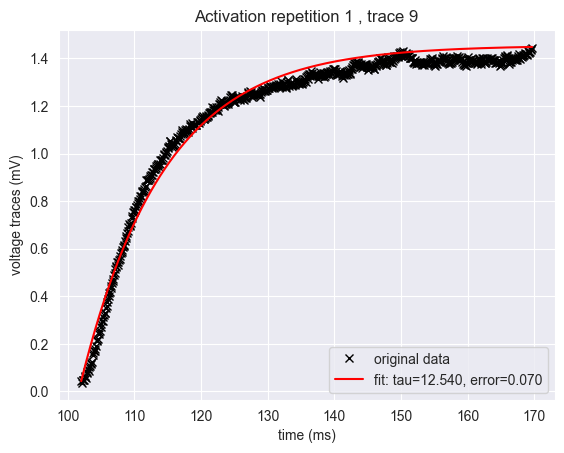

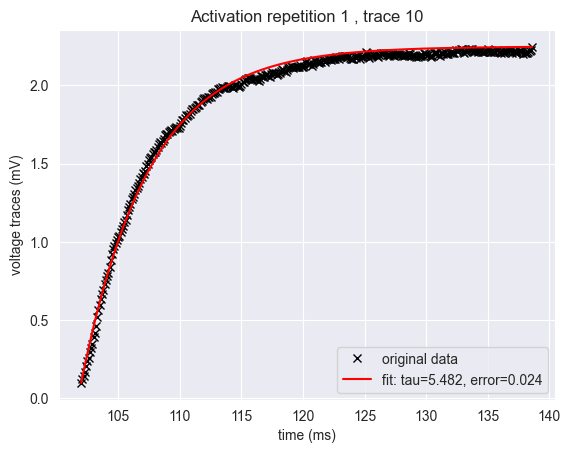

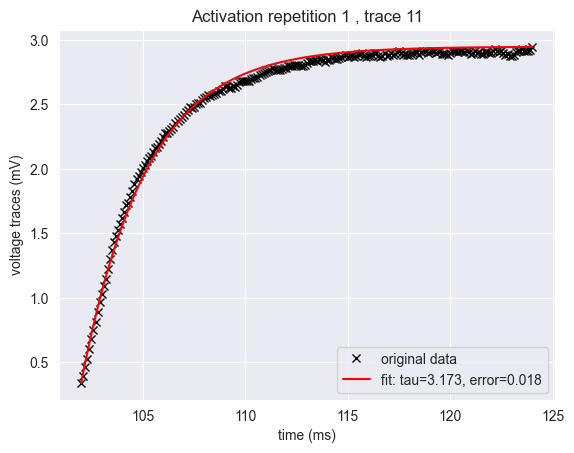

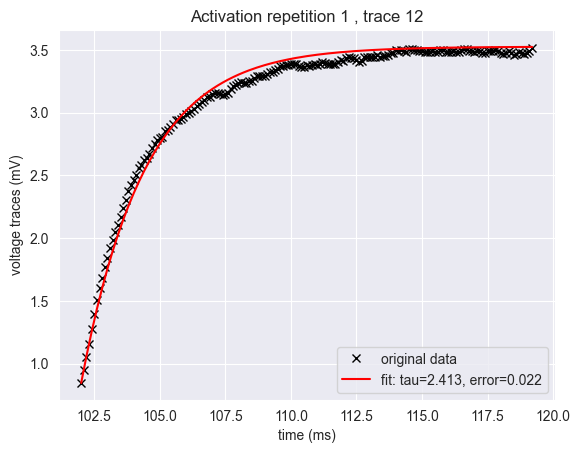

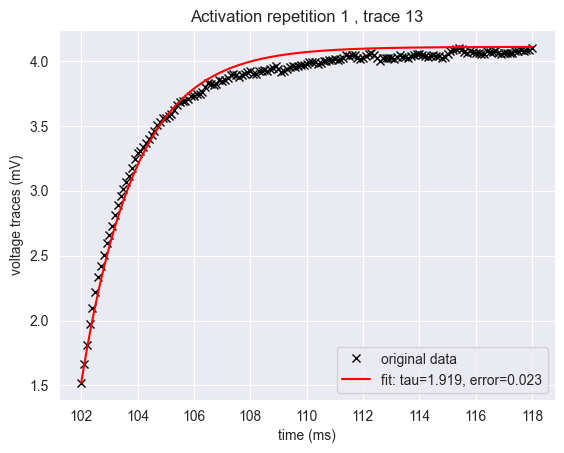

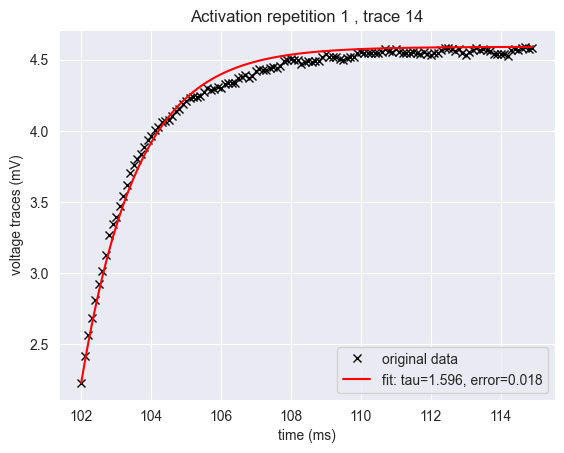

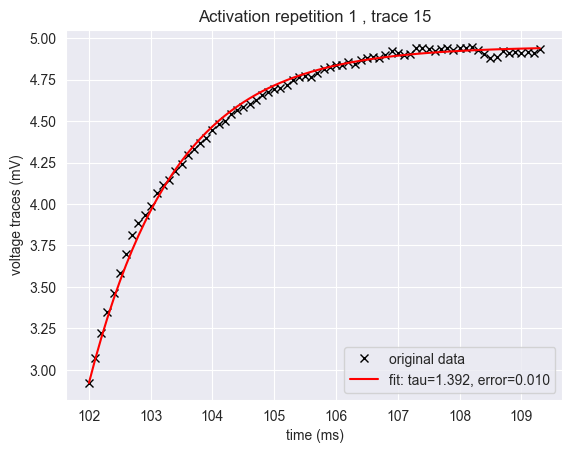

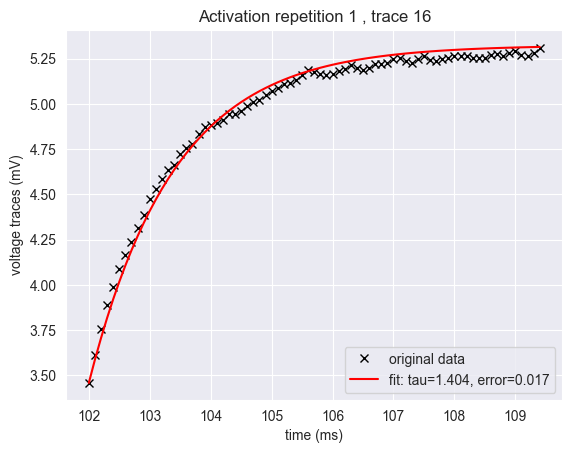

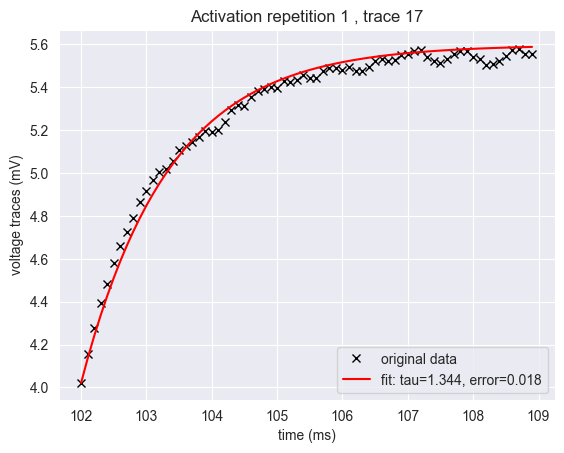

In [117]:
# for repetition 1
pathway = '/acquisition/timeseries/Activation/repetitions/repetition'
repetition = 1
taus=plotDataFiles(data_path, pathway, repetition)

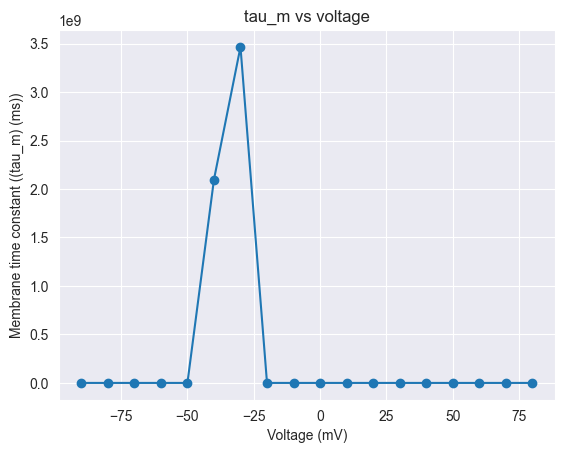

In [92]:
mV=np.linspace(-90,80,18)
for i in range (4) :
    taus[i]=0

plt.figure()
plt.plot(mV,taus)
plt.scatter(mV,taus)
plt.title('tau_m vs voltage')
plt.ylabel('Membrane time constant ((tau_m) (ms))')
plt.xlabel('Voltage (mV)')
plt.show()

# Ex2. Implementing a Potassium channel

<font size=3>

See `SKv3.1.mod`. Your task is to fill it in to implement the following potassium channel model:

$\displaystyle I_K = g_k \times (v - E_k)$
    
Where $I_k$ is potassium current, v is membrane potential, $g_k$ the potassium conductance, and $E_k$ is the reversal potential of potassium (provided for you within the NEURON simulator).

$\displaystyle g_k = \bar{g_k} \times m $
    
Where $\bar{g_k}$ is the maximum potassium conductance and m evolves according to the differential equation:

$\displaystyle m' = \frac{(m_{inf} - m)}{\tau_m}$

$\displaystyle m_{inf} = \frac{1}{1 + e^{\frac{v - v_{half}}{ s_m}}}$
    
$\displaystyle \tau_m = \frac{c_{\tau}}{1 + e^{\frac{v - v_{\tau}}{s_{\tau}}}} $
    
With some values fixed:
    
$s_m = -9.7$
    
$c_{\tau} = 4$
    
$\bar{g_k} = 0.0001 Scm^{-2}$

$v_{\tau} =  -46.560 V$
    
$s_{\tau} = -44$

The remaining parameter, $v_{half}$ we will vary.
    
Next, Create a cell in Neuron with the following characteristics: 
    
 - 1 section (soma) with one segment 15 µm of length and diameter, 
 - 120 Ω*cm of axial radius and 
 - 1.6 µF/cm^2 of capacitance. 
    
Insert the channel you just created.
Add a current clamp stimulus starting at 100ms and lasting 500ms.
    
Vary vhalf for to the values -30, -20, -10, 0, 10, 20. 
For each value of vhalf, vary stimulus amplitude between 0 and 1.5.
Record the maximum membrane potential and potassium conductance for each.
    
plot the I/V curves for each v_half on the same axes. 
explain the meaning of the results.

[2 pts]
    

# Ex3. Finding the rheobase of a cell

<font size = "3"> 
Create a cell in Neuron with the following characteristics: 
    
 - 1 section (soma) with one segment 15 µm of length and diameter, 
 - 120 Ω*cm of axial radius and 
 - 1.6 µF/cm^2 of capacitance. 

Add active sodium and potassium channels using the hodgekin-huxley (hh) mechanism. Set (gNa = 0.09 S and gK = 0.01 S).
hh also includes a passive conductance driving the neuron to its resting potential.
Set hh.el to -70 mV and hh.gl to 0.003 S/cm^2. 
    
Generate a current clamp experiment in which you inject 0.016 mA current into the cell soma with 50 ms delay, 500ms in duration. Use a voltage base of -70 mV and set the total recording duration of the experiment to 800ms. This is your base experiment - plot the injected current and the resulting membrane potential. Vary the injected current to find the rheobase of this cell - what is its amplitude ? What is the threshold potential for this cell? 

Next, inject the rheobase current into the cell for 60 ms followed 200ms later by double rheobase current for only 30ms. Plot the voltage trace. What do you see? Why does this effect occur?
    
Finally, inject rheobase as in the first experiment but vary the sodium conductance with values 0.08, 0.09, 0.12. Plot the voltage traces. Is the excitability of the cell very sensitive to this parameter? How does this relate to the role of sodium channels in action potential generation?
    
<font size = "3">[2 pt]

In [3]:
from neuron import h

--No graphics will be displayed.


#### First experiment: base experiment

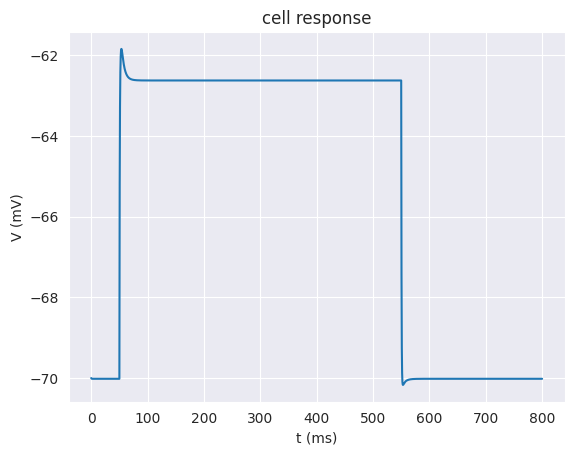

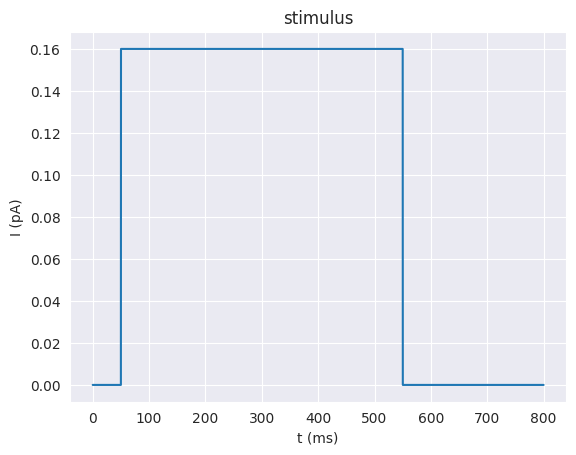

In [5]:
# creating cell
soma = h.Section(name='soma')
soma.L = 15 #µm
soma.diam = 15 #µm
soma.Ra = 120 #Ω*cm
soma.cm = 1.6 #µF/cm^2

# adding properties
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.01   # S 
    seg.hh.gnabar = 0.09  # S
    seg.hh.gl = 0.003 # S/cm^2
    seg.hh.el = -70 # mV
     
# Insert current clamp experiment
stim = h.IClamp(soma(0.5))        
stim.delay = 50   # ms
stim.dur = 500     # ms
stim.amp = 0.16


# Initialize vectors
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)

h.load_file('stdrun.hoc')
h.finitialize(-70)
h.continuerun(800)

plt.figure()
plt.title('cell response')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)
# plt.ylim(top=-69)

plt.figure()
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

#### Second experiment: find rheobase

Rheobase current: 0.22253 pA
Threshold potential: -51.70979 mV


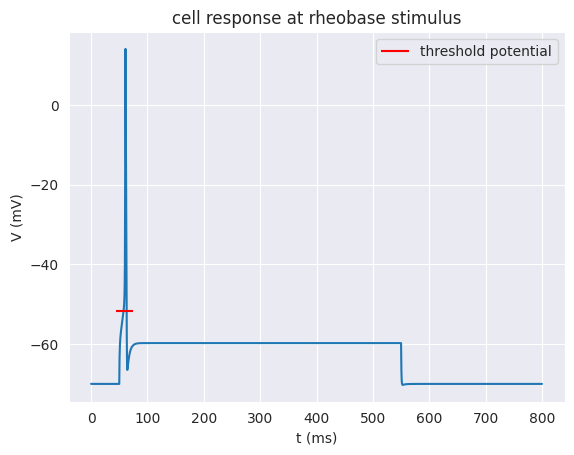

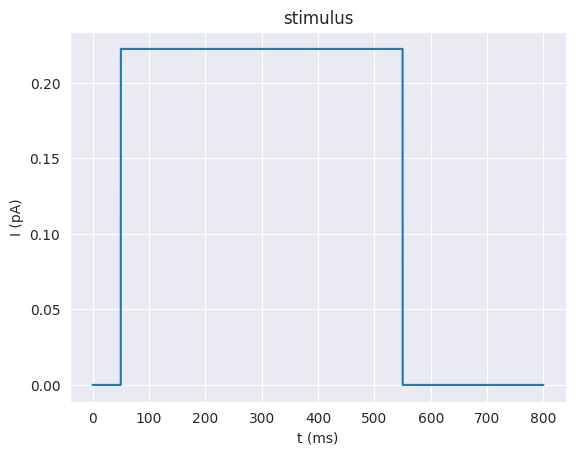

In [6]:
for i in np.linspace(0.22, 0.23, 100): # set through trial and error
    stim.amp = i
    
    # Initialize vectors
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    h.finitialize(-70)
    h.continuerun(800)
    
    # rheobase current found at the first iteration in which the membrane potential exceeds 0 (AP fired)
    cell_v = np.array(rec_v)
    
    if np.any(cell_v>0):
        rheobase = i
        break
    
    # threshold potential is the maximum potential reached at the iteration right before the rheobase one
    thr_time = np.argmax(cell_v)
    thr_pot = cell_v[thr_time]
    thr_ms = thr_time / len(cell_v) *800
    
print("Rheobase current: {:.5f} pA".format(rheobase))
print("Threshold potential: {:.5f} mV".format(thr_pot))

plt.figure()
plt.title('cell response at rheobase stimulus')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)
plt.hlines(thr_pot, thr_ms-15, thr_ms+15, colors='red', label='threshold potential')
plt.legend()

plt.figure()
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_i);

#### Third experiment: two stimuli

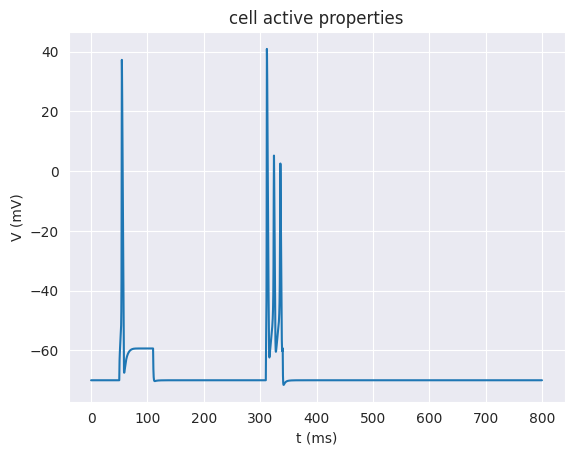

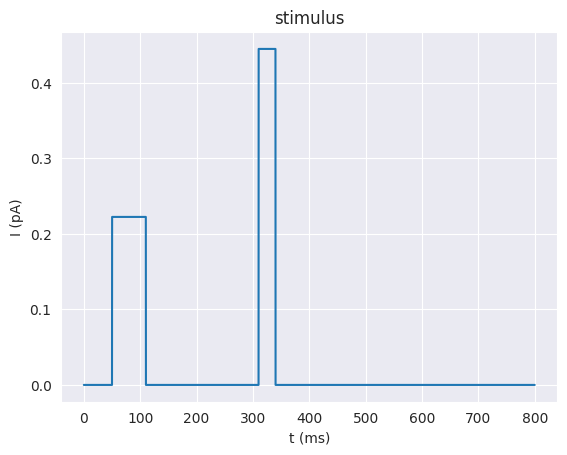

In [8]:
# new stimulation with rheobase current 
stim = h.IClamp(soma(0.5))        
stim.delay = 50   # ms
stim.dur = 60     # ms
stim.amp = rheobase 

stim2 = h.IClamp(soma(0.5))
stim2.delay = 200+50+60
stim2.dur = 30
stim2.amp = rheobase*2

# Initialize vectors
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)
rec_i2 = h.Vector()
rec_i2.record(stim2._ref_i)

h.finitialize(-70)
h.continuerun(800)

plt.figure()
plt.title('cell active properties')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v)

plt.figure()
plt.title('stimulus')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,np.array(rec_i) + np.array(rec_i2));


The first stimulus lasts long enough to evoke one action potential in the cell.  
The second one, even if of shorter duration, has higher intensity. This causes the cell to fire a burst of three action potentials (firing throught the whole stimulation period).  

In summary, even though the total electric charge is the same in both stimuli, the cell responds in two very different ways depending on its properties. In the second case the depolarization force is stronger, resulting in a burst of action potentials.

#### Fourth experiment: change sodium conductances

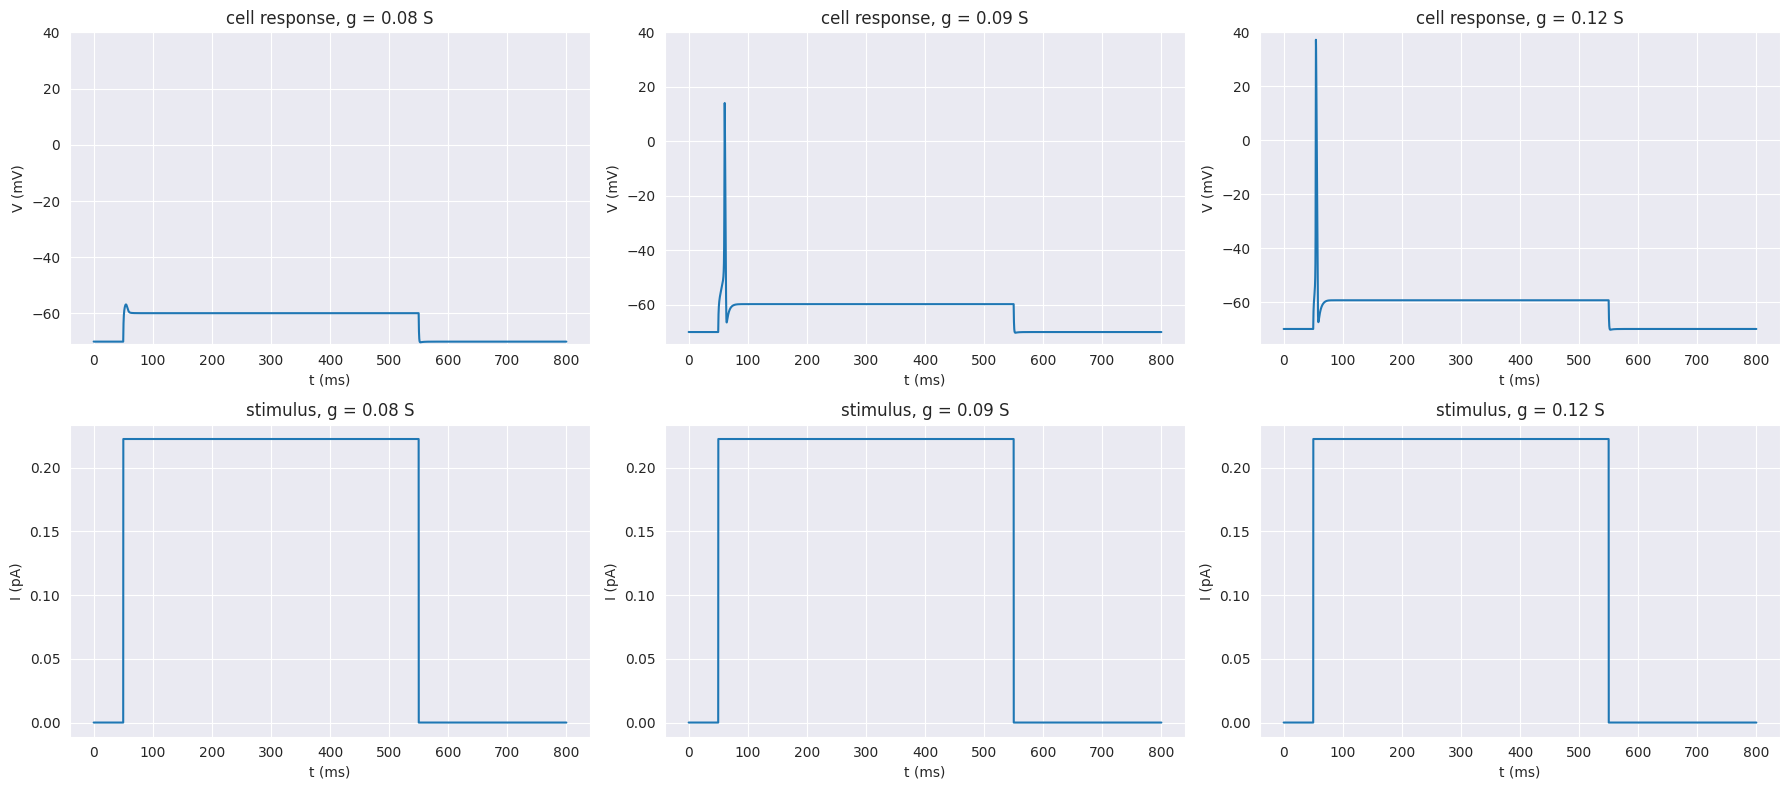

In [14]:
# creating cell
soma = h.Section(name='soma')
soma.L = 15 #µm
soma.diam = 15 #µm
soma.Ra = 120 #Ω*cm
soma.cm = 1.6 #µF/cm^2

# adding properties
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.01   # S 
    seg.hh.gl = 0.003 # S/cm^2
    seg.hh.el = -70 # mV
    
time_vects = []
volt_vects = []
stim_vects = []

conductances = [0.08, 0.09, 0.12]

h.load_file('stdrun.hoc')

    
for cond in conductances:
    for seg in soma:
        seg.hh.gnabar = cond  # S
     
    # Insert current clamp experiment
    stim = h.IClamp(soma(0.5))        
    stim.delay = 50   # ms
    stim.dur =500     # ms
    stim.amp = rheobase   


    # Initialize vectors
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    h.finitialize(-70)
    h.continuerun(800)
    
    time_vects.append(np.array(rec_t))
    volt_vects.append(np.array(rec_v))
    stim_vects.append(np.array(rec_i))
        
    
fig, axs = plt.subplots(2,3, figsize=(18,8))

for i in range(3):
    axs[0][i].plot(time_vects[i], volt_vects[i])
    axs[0][i].set_title("cell response, g = {} S".format(conductances[i]))
    axs[0][i].set_ylabel('V (mV)')
    axs[0][i].set_xlabel('t (ms)')
    axs[0][i].set_ylim(top=40)
    
    axs[1][i].plot(time_vects[i], stim_vects[i])
    axs[1][i].set_title("stimulus, g = {} S".format(conductances[i]))
    axs[1][i].set_ylabel('I (pA)')
    axs[1][i].set_xlabel('t (ms)')

plt.tight_layout()



The cell response is sensitive to changes of sodium channels conductances. Increasing the conductance allows a faster depolarization when the stimulus is presented because more ions can enter the neuron. As a result, the higher the conductance, the stronger the neuron's response.  

In this case, the lowest conductance is not enough to reach the threshold potential at the rheobase current computed for gNA = 0.09S. Instead, the response to the stimulus of the cell with the highest conductance is extremely fast and strong, reaching a very high peak. 